In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt




In [2]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
tickers = ['688232.SS','002115.SS','300557.SZ','300487.SZ','688212.SS','600600.SS','603380.SS']

In [26]:

ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(365)
end = dt.datetime.today()

In [27]:
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
    
    if len(ohlc_mon[ticker])<10: #removing tickers that have too few data points
        del ohlc_mon[ticker]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
tickers=ohlc_mon.keys()
tickers

dict_keys(['300557.SZ', '300487.SZ', '600600.SS', '603380.SS'])

In [29]:
#monthly return
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

calculating monthly return for  300557.SZ
calculating monthly return for  300487.SZ
calculating monthly return for  600600.SS
calculating monthly return for  603380.SS


In [30]:
return_df

,300557.SZ,300487.SZ,600600.SS,603380.SS
Date,,,,
2021-02-01,0.008647,-0.030303,-0.103165,0.020285
2021-03-01,0.148307,0.000000,0.062916,0.200967
2021-04-01,-0.093692,0.197000,0.075260,-0.032662
2021-05-01,0.023064,0.512114,0.153060,0.066142
2021-06-01,0.064815,0.168508,0.102058,0.042083
2021-07-01,0.066163,0.057194,-0.305837,0.153206
2021-08-01,0.002482,0.098419,0.075237,0.071061
2021-09-01,-0.085957,-0.251046,-0.058982,0.008877
2021-10-01,-0.041796,0.068402,0.294921,-0.015567


In [31]:
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [32]:
CAGR(pflio(return_df,3,1))
sharpe(pflio(return_df,3,1),0.025)
max_dd(pflio(return_df,3,1)) 

['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '603380.SS']
['603380.SS', '603380.SS', '300487.SZ']
['300487.SZ', '300487.SZ', '600600.SS']
['300487.SZ', '300487.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300487.SZ', '300487.SZ']
['603380.SS', '603380.SS', '600600.SS']
['600600.SS', '600600.SS', '300487.SZ']
['300487.SZ', '603380.SS', '300487.SZ']
['603380.SS', '600600.SS', '300557.SZ']
['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '603380.SS']
['603380.SS', '603380.SS', '300487.SZ']
['300487.SZ', '300487.SZ', '600600.SS']
['300487.SZ', '300487.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300487.SZ', '300487.SZ']
['603380.SS', '603380.SS', '600600.SS']
['600600.SS', '600600.SS', '300487.SZ']
['300487.SZ', '603380.SS', '300487.SZ']
['603380.SS', '600600.SS', '300557.SZ']
['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '300487.SZ']


0.1644051126167106

['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '603380.SS']
['603380.SS', '603380.SS', '300487.SZ']
['300487.SZ', '300487.SZ', '600600.SS']
['300487.SZ', '300487.SZ', '300487.SZ']
['603380.SS', '300557.SZ', '300487.SZ']
['603380.SS', '300487.SZ', '300487.SZ']
['603380.SS', '603380.SS', '600600.SS']
['600600.SS', '600600.SS', '300487.SZ']
['300487.SZ', '603380.SS', '300487.SZ']
['603380.SS', '600600.SS', '300557.SZ']
['603380.SS', '300557.SZ', '300487.SZ']


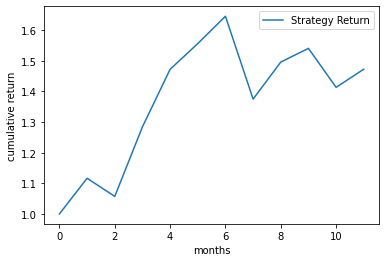

In [33]:
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,3,1)).cumprod());
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return"])